In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
import re,nltk,json, pickle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM,GRU
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
np.random.seed(42)
class color: # Text style
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

2021-08-06 15:53:24.249706: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
# Warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [3]:
import tensorflow as tf
print(tf.__version__)

2.5.0


In [4]:
print(tf.keras.__version__)

2.5.0


In [5]:
# Read the data
data = pd.read_csv("Conversation.csv")
data

,Conversation,Sentiment
0,আমি বুথ থেকে কল দেয়ার জন্য দুঃখিত,negative
1,আমি তোমার সম্পর্কে দুঃখিত,negative
2,আমার ভয় হচ্ছিল আমি খুব ভয় পেয়েছিলাম,negative
3,অবশ্যই ধন্যবাদ,positive
4,কী সুন্দর!! আমি খুব খুশি,positive
...,...,...
1136,"ওই, কে রে শালা তুই?",negative
1137,সবকিছুই পরিকল্পনা মাফিক হবে,positive
1138,তুই কোন নরক থেকে এসেছিস রে?,negative
1139,এখানেই মরবি তুই।,negative


In [7]:
data = data[['Conversation','Sentiment']]

In [8]:
data

,Conversation,Sentiment
0,আমি বুথ থেকে কল দেয়ার জন্য দুঃখিত,negative
1,আমি তোমার সম্পর্কে দুঃখিত,negative
2,আমার ভয় হচ্ছিল আমি খুব ভয় পেয়েছিলাম,negative
3,অবশ্যই ধন্যবাদ,positive
4,কী সুন্দর!! আমি খুব খুশি,positive
...,...,...
1136,"ওই, কে রে শালা তুই?",negative
1137,সবকিছুই পরিকল্পনা মাফিক হবে,positive
1138,তুই কোন নরক থেকে এসেছিস রে?,negative
1139,এখানেই মরবি তুই।,negative


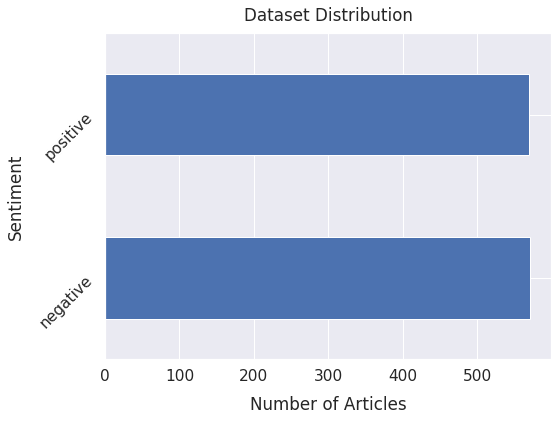

In [10]:
# Plot the Class distribution
sns.set(font_scale=1.4)
data['Sentiment'].value_counts().plot(kind='barh', figsize=(8, 6))
plt.xlabel("Number of Articles", labelpad=12)
plt.ylabel("Sentiment", labelpad=12)
plt.yticks(rotation = 45)
plt.title("Dataset Distribution", y=1.02);

In [11]:
# Cleaning Data [Remove unncessary symbols]
def cleaning_documents(articles):
      '''
      This function will clean the news articles by removing punctuation marks and stopwords.

      Args:
      articles: a news text(str)

      returns:
      news: clean text (str)
      '''
      news = articles.replace('\n',' ')
      news = re.sub('[^\u0980-\u09FF]',' ',str(news)) #removing unnecessary punctuation
      # stopwords removal
      stp = open('bangla_stopwords.txt','r').read().split()
      result = news.split()
      news = [word.strip() for word in result if word not in stp ]
      news =" ".join(news)
      return news

In [13]:
# Apply the function into the dataframe
data['cleaned'] = data['Conversation'].apply(cleaning_documents)

In [15]:
# print some cleaned documents from the dataset
sample_data = [5,10,16,39,57,67,70,100]
for i in sample_data:
  print('Original:\n',data.Conversation[i],'\nCleaned:\n',
           data.cleaned[i],'\n','sentiment:-- ',data.Sentiment[i],'\n')

Original:
 আমিও তার জানাজায় ছিলাম 
Cleaned:
 আমিও জানাজায় ছিলাম 
 sentiment:--  negative 

Original:
 দুর্দান্ত তুমি কি তাতে খুশি?  হ্যাঁ, আমি শিহরিত খুঁজে পেয়েছি! 
Cleaned:
 দুর্দান্ত খুশি হ্যাঁ শিহরিত খুঁজে পেয়েছি 
 sentiment:--  positive 

Original:
 আমার অবস্থা বর্ণনা করা কঠিন ছিল 
Cleaned:
 অবস্থা বর্ণনা কঠিন 
 sentiment:--  negative 

Original:
 আমি সত্যিই আপনার সাথে কথা বলছি 
Cleaned:
 সত্যিই বলছি 
 sentiment:--  positive 

Original:
 তোমার সাথে থাকাই আমার সব খুশি ছিল
 
Cleaned:
 থাকাই খুশি 
 sentiment:--  positive 

Original:
 তোমরা দুজনেই দেখা করার জন্য যথেষ্ট ভাগ্যবান ছিলে 
Cleaned:
 তোমরা দুজনেই ভাগ্যবান ছিলে 
 sentiment:--  positive 

Original:
 আমার মনে হয় যে আমি তার প্রেমে পড়েছি 
Cleaned:
 প্রেমে পড়েছি 
 sentiment:--  positive 

Original:
 আমি প্রতিজ্ঞা করব পরের বর্ষায় ফিরে আসতে 
Cleaned:
 প্রতিজ্ঞা করব পরের বর্ষায় আসতে 
 sentiment:--  positive 



In [16]:
# Stopwords pickle 
stp = open('bangla_stopwords.txt','r',encoding='utf-8').read().split()
# open a file, where you ant to store the data
file = open('bangla_stopwords.pkl', 'wb')
# dump information to that file
pickle.dump(stp, file)

In [17]:
stp = open('bangla_stopwords.pkl','rb')
stp = pickle.load(stp)
len(stp)

410

In [18]:
# Calculate the Length of each Document
data['Length'] = data.cleaned.apply(lambda x:len(x.split()))

# Remove the Documents with least words
dataset = data.loc[data.Length>0]
dataset = dataset.reset_index(drop = True)
print("After Cleaning:","\nRemoved {} Small Documents".format(len(data)-len(dataset)),
      "\nTotal Remaining Documents:",len(dataset))

After Cleaning: 
Removed 7 Small Documents 
Total Remaining Documents: 1134


In [19]:
# Save the Cleaned data for reuse
dataset.to_csv('cleaned_data.csv')

In [20]:
# Load the Cleaned News
dataset = pd.read_csv('cleaned_data.csv')
dataset.columns

Index(['Unnamed: 0', 'Conversation', 'Sentiment', 'cleaned', 'Length'], dtype='object')

In [21]:
dataset.head(5)

,Unnamed: 0,Conversation,Sentiment,cleaned,Length
0,0,আমি বুথ থেকে কল দেয়ার জন্য দুঃখিত,negative,বুথ কল দেয়ার দুঃখিত,4
1,1,আমি তোমার সম্পর্কে দুঃখিত,negative,সম্পর্কে দুঃখিত,2
2,2,আমার ভয় হচ্ছিল আমি খুব ভয় পেয়েছিলাম,negative,ভয় হচ্ছিল ভয় পেয়েছিলাম,4
3,3,অবশ্যই ধন্যবাদ,positive,অবশ্যই ধন্যবাদ,2
4,4,কী সুন্দর!! আমি খুব খুশি,positive,সুন্দর খুশি,2


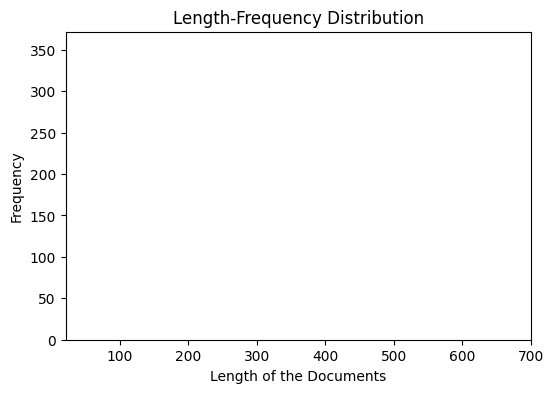

Maximum Length of a Document: 16
Minimum Length of a Document: 1
Average Length of a Document: 3.0


In [22]:
#Document length distribution
import matplotlib
matplotlib.rc_file_defaults()
frequency = dict()
for i in dataset.Length:
    frequency[i] = frequency.get(i, 0)+1

plt.figure(figsize = (6,4))
plt.bar(frequency.keys(), frequency.values(), color=(0.2, 0.4, 0.6, 0.6))
plt.xlim(21, 700)
# in this notbook color is not working but it should work.
plt.xlabel('Length of the Documents')
plt.ylabel('Frequency')
plt.title('Length-Frequency Distribution')
#plt.savefig('len_dist.png',dpi = 1000,bbox_inches ='tight')
plt.show()  
print(f"Maximum Length of a Document: {max(dataset.Length)}")
print(f"Minimum Length of a Document: {min(dataset.Length)}")
print(f"Average Length of a Document: {round(np.mean(dataset.Length),0)}")

In [24]:
#Dataset Summary
def data_summary(dataset):

  documents = []
  words = []
  u_words = []
  #total_u_word = [word.strip().lower() for t in list(dataset.cleaned) for word in t.strip().split()]
  # find class names
  class_label = [k for k,v in dataset.Sentiment.value_counts().to_dict().items()]
  for label in class_label: 
    word_list = [word.strip().lower() for t in list(dataset[dataset.Sentiment==label].cleaned) for word in t.strip().split()]
    counts = dict()
    for word in word_list:
      counts[word] = counts.get(word, 0)+1
    # sort the dictionary of word list  
    ordered = sorted(counts.items(), key= lambda item: item[1],reverse = True)
    # Documents per class
    documents.append(len(list(dataset[dataset.Sentiment==label].cleaned)))
    # Total Word per class
    words.append(len(word_list))
    # Unique words per class 
    u_words.append(len(np.unique(word_list)))
       
    print("\nClass Name : ",label)
    print("Number of Documents:{}".format(len(list(dataset[dataset.Sentiment==label].cleaned))))  
    print("Number of Words:{}".format(len(word_list))) 
    print("Number of Unique Words:{}".format(len(np.unique(word_list)))) 
    print("Most Frequent Words:\n")
    for k,v in ordered[:10]:
      print("{}\t{}".format(k,v))
  return documents,words,u_words,class_label

# pass the whole dataset into the function

documents,words,u_words,class_names = data_summary(dataset)


Class Name :  positive
Number of Documents:568
Number of Words:1799
Number of Unique Words:1039
Most Frequent Words:

সুন্দর	29
খুশি	27
জীবন	17
ধন্যবাদ	16
ভালো	16
পছন্দ	15
প্রেমে	12
চাই	11
বড়	10
বিয়ে	10

Class Name :  negative
Number of Documents:566
Number of Words:1719
Number of Unique Words:973
Most Frequent Words:

মারা	37
তুই	25
শালা	20
কর	17
মেরে	17
দুঃখিত	16
কষ্ট	16
তোর	14
বন্ধ	13
চুপ	13


In [25]:
data_matrix = pd.DataFrame({'Total Documents':documents,
                            'Total Words':words,
                            'Unique Words':u_words,
                            'Class Names':class_names})
data_matrix

,Total Documents,Total Words,Unique Words,Class Names
0,568,1799,1039,positive
1,566,1719,973,negative


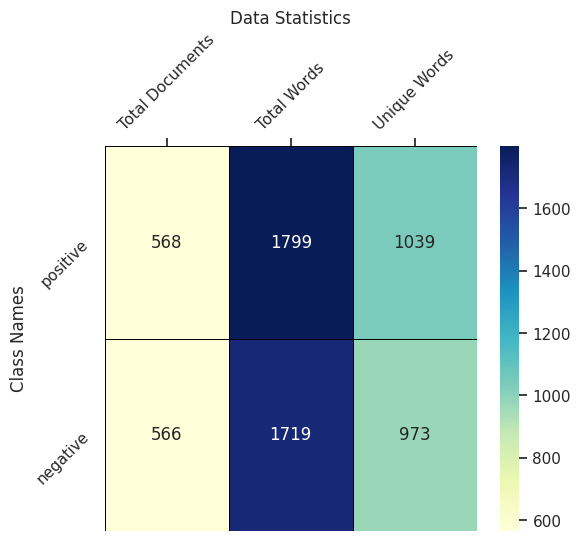

In [26]:
#Data Summary Visualization
sns.set()
plt.figure(figsize =(6, 5))
ax = plt.subplot()
sns.heatmap(data_matrix.iloc[:,0:3], annot=True,fmt="d", linewidths=0.5,linecolor = 'Black',cmap = "YlGnBu",ax = ax)
# labels, title and ticks
ax.set_ylabel('Class Names') 
ax.set_title('Data Statistics')
y_label = ["Total Documents", "Total Words", "Unique Words"] 
ax.xaxis.set_ticklabels(y_label, rotation=45); ax.yaxis.set_ticklabels(class_names, rotation=45);
ax.xaxis.tick_top()

In [32]:
#===========================================================
                   ################# Label Encoding Function ##################
                   #===========================================================
def label_encoding(dataset,bool):

  le = LabelEncoder()
  le.fit(dataset.Sentiment)
  encoded_labels = le.transform(dataset.Sentiment)
  labels = np.array(encoded_labels) # Converting into numpy array
  class_names =le.classes_ ## Define the class names again
  if bool == True:
    print(color.BOLD+"\n\t\t\t===== Label Encoding ====="+color.END,"\nClass Names:-->",le.classes_)
  return labels  

                   #===========================================================
                   ################# Dataset Splitting Function ###############
                   #=========================================================== 

def dataset_split(news,category):
  '''
  This function will split the dataset into Train-Test-Validation set

  Args:
  news: encoded texts
  category: class names

  returns:
  X_train: Encoded Training News  
  X_valid: Encoded Validation News
  X_test:  Encoded Test news
  y_train: Encoded Training labels
  y_valid: Encoded Validation labels
  y_test:  Encoded Test labels
  '''

  X,X_test,y,y_test = train_test_split(news,category,train_size = 0.9,
                                                  test_size = 0.1,random_state =0)
  X_train,X_valid,y_train,y_valid = train_test_split(X,y,train_size = 0.8,
                                                  test_size = 0.2,random_state =0)
  print(color.BOLD+"Feature Size :======>"+color.END,X_train.shape[1])
  print(color.BOLD+"\nDataset Distribution:\n"+color.END)
  print("\tSet Name","\t\tSize")
  print("\t========\t\t======")

  print("\tFull\t\t\t",news.shape[0],
        "\n\tTraining\t\t",X_train.shape[0],
        "\n\tTest\t\t\t",X_test.shape[0],
        "\n\tValidation\t\t",X_valid.shape[0])
  
  return X_train,X_valid,X_test,y_train,y_valid,y_test

In [33]:
def encoded_texts(dataset,padding_length,max_words):

  '''
  This function will encoded the text into a sequence of numbers

  Args:
  dataset: a dataset
  padding_length: maximum length of a encoded texte
  max_words : Number of words 

  returns:
  corpus: Number of encoded texts
  labels: encoded labels
  '''
  
  tokenizer = Tokenizer(num_words = max_words, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n-', 
                      split=' ', char_level=False, oov_token='<oov>', document_count=0)
  
 

 # Fit the tokenizer
  tokenizer.fit_on_texts(dataset.cleaned)
  #============================== Tokenizer Info =================================
  (word_counts,word_docs,word_index,document_count) = (tokenizer.word_counts,
                                                       tokenizer.word_docs,
                                                       tokenizer.word_index,
                                                       tokenizer.document_count)
  def tokenizer_info(mylist,bool):
    ordered = sorted(mylist.items(), key= lambda item: item[1],reverse = bool)
    for w,c in ordered[:10]:
      print(w,"\t",c)
  #=============================== Print all the information =========================
  print(color.BOLD+"\t\t\t====== Tokenizer Info ======"+color.END)   
  print("Words --> Counts:")
  tokenizer_info(word_counts,bool =True )
  print("\nWords --> Documents:")
  tokenizer_info(word_docs,bool =True )
  print("\nWords --> Index:")
  tokenizer_info(word_index,bool =True )    
  print("\nTotal Documents -->",document_count)

  #=========================== Convert string into list of integer indices =================
  sequences = tokenizer.texts_to_sequences(dataset.cleaned)
  word_index = tokenizer.word_index
  print(color.BOLD+"\n\t\t\t====== Encoded Sequences ======"+color.END,"\nFound {} unique tokens".format(len(word_index)))  
  print(dataset.cleaned[10],"\n",sequences[10]) 

  #==================================== Pad Sequences ============================== 
  corpus = keras.preprocessing.sequence.pad_sequences(sequences, value=0.0,
                                                      padding='post', maxlen= padding_length)
  print("\n\t\t\t====== Paded Sequences ======\n",dataset.cleaned[10],"\n",corpus[10])   

  #=================================     Label Encoding ================================
  labels = label_encoding(dataset,True)

   # save the tokenizer into a pickle file
  with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

  return corpus,labels
  
#call the function
num_words = 5000
corpus,labels = encoded_texts(dataset,
                                300,num_words)
print("\nShape of Encoded Corpus =====>",corpus.shape)

			====== Tokenizer Info ======
Words --> Counts:
মারা 	 37
তুই 	 31
সুন্দর 	 29
খুশি 	 27
কর 	 22
জীবন 	 20
শালা 	 20
তোর 	 18
কষ্ট 	 17
পছন্দ 	 17

Words --> Documents:
মারা 	 36
সুন্দর 	 29
তুই 	 29
খুশি 	 27
কর 	 22
জীবন 	 20
শালা 	 20
পছন্দ 	 17
দুঃখিত 	 16
কষ্ট 	 16

Words --> Index:
ফেলা 	 1767
মরবি 	 1766
মাফিক 	 1765
সবকিছুই 	 1764
আছেন৷ 	 1763
বিপদে 	 1762
চোর৷ 	 1761
ঠকিয়েছে 	 1760
শয়তান 	 1759
ছেলেটার 	 1758

Total Documents --> 1134

			====== Encoded Sequences ====== 
Found 1767 unique tokens
দুর্দান্ত খুশি হ্যাঁ শিহরিত খুঁজে পেয়েছি 
 [152, 5, 214, 589, 79, 102]

			====== Paded Sequences ======
 দুর্দান্ত খুশি হ্যাঁ শিহরিত খুঁজে পেয়েছি 
 [152   5 214 589  79 102   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0

In [34]:
#Call Dataset Validation
X_train,X_valid,X_test,y_train,y_valid,y_test = dataset_split(corpus,labels)

Feature Size :======> 300

Dataset Distribution:

	Set Name 		Size
	========		======
	Full			 1134 
	Training		 816 
	Test			 114 
	Validation		 204


In [35]:
embedding_dimension = 128
input_length = 300
vocab_size = 5000
num_classes = 2
batch_size = 128
num_epochs = 10

accuracy_threshold = 0.97


class myCallback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
      if(logs.get('accuracy')>accuracy_threshold):
        print("\nReached %2.2f%% accuracy so we will stop trianing" % (accuracy_threshold*100))
        self.model.stop_training = True

acc_callback = myCallback()
# Saved the Best Model
filepath = "Model.h5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=2, save_best_only=True, 
                                             save_weights_only=False, mode='max')
# callback list
callback_list = [acc_callback, checkpoint] 

                            ###############################     CNN network architecture ################
model = tf.keras.models.Sequential([
tf.keras.layers.Embedding(vocab_size, embedding_dimension, input_length = input_length),
tf.keras.layers.Conv1D(128, 5, activation= 'relu'),
tf.keras.layers.MaxPooling1D(5),
tf.keras.layers.Bidirectional(LSTM(64, return_sequences=True,dropout = 0.1)),
tf.keras.layers.Bidirectional(LSTM(64, return_sequences=True,dropout = 0.1)),
tf.keras.layers.Dense(28, activation='relu'),
tf.keras.layers.Dense(14, activation='relu'),
keras.layers.Flatten(),
tf.keras.layers.Dense(num_classes , activation='softmax')])

model.summary()

model.compile(optimizer=keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])
   
history = model.fit(X_train,
    y_train,
    epochs=num_epochs,
    batch_size = batch_size,
    validation_data=(X_valid, y_valid),
    verbose =1)
    #callbacks = callback_list)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 128)          640000    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 296, 128)          82048     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 59, 128)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 59, 128)           98816     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 59, 128)           98816     
_________________________________________________________________
dense_3 (Dense)              (None, 59, 28)            3612      
_________________________________________________________________
dense_4 (Dense)              (None, 59, 14)           

2021-08-06 15:59:34.877931: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-08-06 15:59:34.896355: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2400000000 Hz


7/7 [==============================] - 10s 640ms/step - loss: 0.6950 - accuracy: 0.4853 - val_loss: 0.6943 - val_accuracy: 0.4608
Epoch 2/10
7/7 [==============================] - 3s 426ms/step - loss: 0.6933 - accuracy: 0.4890 - val_loss: 0.6944 - val_accuracy: 0.4608
Epoch 3/10
7/7 [==============================] - 3s 438ms/step - loss: 0.6935 - accuracy: 0.4743 - val_loss: 0.6970 - val_accuracy: 0.4608
Epoch 4/10
7/7 [==============================] - 3s 412ms/step - loss: 0.6937 - accuracy: 0.5098 - val_loss: 0.6960 - val_accuracy: 0.4608
Epoch 5/10
7/7 [==============================] - 3s 411ms/step - loss: 0.6937 - accuracy: 0.5098 - val_loss: 0.6943 - val_accuracy: 0.4608
Epoch 6/10
7/7 [==============================] - 3s 411ms/step - loss: 0.6914 - accuracy: 0.5184 - val_loss: 0.6888 - val_accuracy: 0.6814
Epoch 7/10
7/7 [==============================] - 3s 413ms/step - loss: 0.6749 - accuracy: 0.7574 - val_loss: 0.6683 - val_accuracy: 0.5392
Epoch 8/10
7/7 [==============

In [37]:
# save the model
tf.keras.models.save_model(model, 'Document_Categorization.h5', save_format='h5')
#model.save('Document_Categorization.h5')

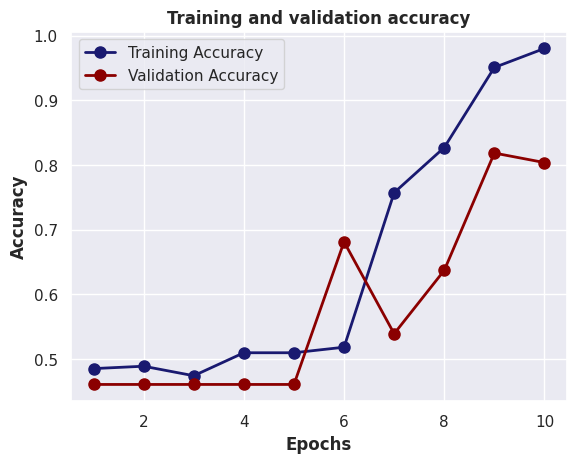

In [38]:
loss_values = history.history['loss']
val_loss_values = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)
sns.set_style('darkgrid')
                  #=========================================================
                  ############### Epochs vs Validation Accuracy Plot ##########
                  #==========================================================

plt.plot(epochs, acc, color='midnightblue', linewidth = 2, 
          marker='o', markersize=8,label='Training Accuracy')
plt.plot(epochs, val_acc, color='darkred', linewidth = 2, 
          marker='o', markersize=8,label='Training Accuracy')
plt.title('Training and validation accuracy',fontsize=12,fontweight='bold')
plt.xlabel('Epochs',fontsize=12,fontweight='bold')
plt.ylabel('Accuracy',fontsize=12,fontweight='bold')
plt.legend(['Training Accuracy','Validation Accuracy'])

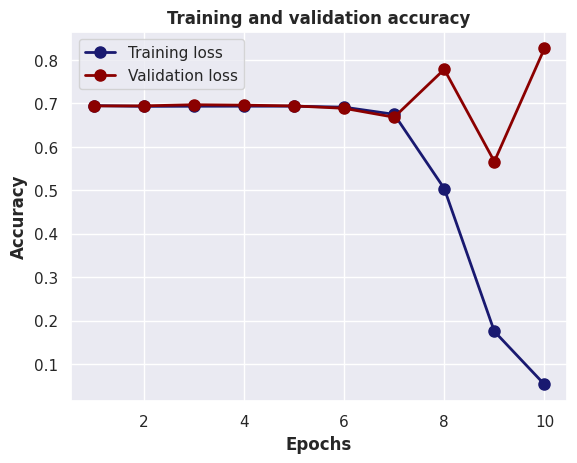

In [39]:
plt.plot(epochs, loss_values, color='midnightblue', linewidth = 2, 
          marker='o', markersize=8,label='Training Accuracy')
plt.plot(epochs, val_loss_values, color='darkred', linewidth = 2, 
          marker='o', markersize=8,label='Training Accuracy')
plt.title('Training and validation accuracy',fontsize=12,fontweight='bold')
plt.xlabel('Epochs',fontsize=12,fontweight='bold')
plt.ylabel('Accuracy',fontsize=12,fontweight='bold')
plt.legend(['Training loss','Validation loss'])

In [40]:
# Load the saved model
model = load_model('Document_Categorization.h5')

In [41]:
#class_names = ['anger' ,'happy' ,'neutral', 'sad']
class_names = ['positive' ,'negative']
predictions = model.predict(X_test)
y_pred = np.argmax(predictions, axis=1)
report = pd.DataFrame(classification_report(y_true = y_test, y_pred = y_pred, output_dict=True)).transpose()
report = report.rename(index={'0': 'positive','1':'negative'})
report[['precision','recall','f1-score']]=report[['precision','recall','f1-score']].apply(lambda x: round(x*100,2))
report

,precision,recall,f1-score,support
positive,78.57,78.57,78.57,56.000000
negative,79.31,79.31,79.31,58.000000
accuracy,78.95,78.95,78.95,0.789474
macro avg,78.94,78.94,78.94,114.000000
weighted avg,78.95,78.95,78.95,114.000000


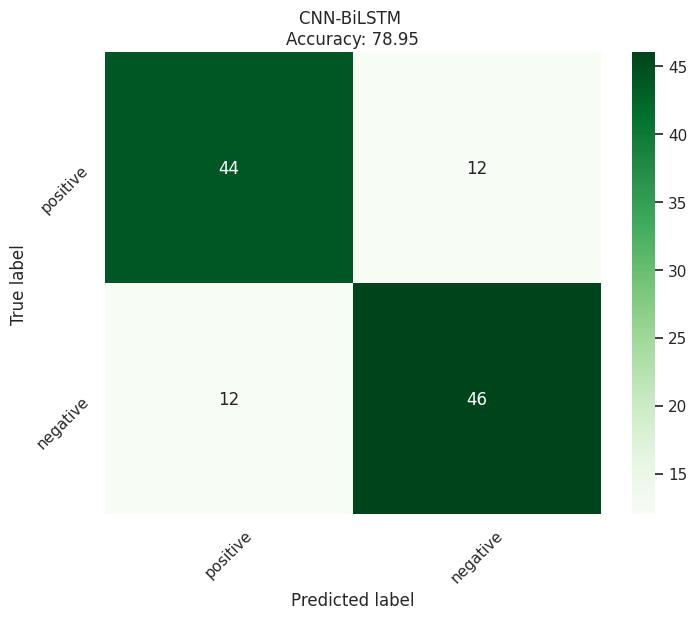

In [42]:
#Confusion Matrix
from sklearn.metrics import classification_report, confusion_matrix
predictions = model.predict(X_test)
y_pred = np.argmax(predictions, axis=1)

cm = confusion_matrix(y_test, y_pred) 

class_names = ['positive' ,'negative']
# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = class_names, 
                     columns = class_names)

plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True,cmap="Greens", fmt='g')
plt.title('CNN-BiLSTM \nAccuracy: {0:.2f}'.format(accuracy_score(y_test, y_pred)*100))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.xticks(rotation = 45)
plt.yticks(rotation = 45)
plt.show()

In [43]:
sample_news = 'আসতেছে আমার'
cleaned_news = cleaning_documents(sample_news)

#class_names = ['anger', 'happy', 'neutral', 'sad']
class_names = ['positive' ,'negative']

#print(cleaned_news)
# load the saved tokenizer
with open('tokenizer.pickle', 'rb') as handle:
    loaded_tokenizer = pickle.load(handle)
#print(len(loaded_tokenizer.word_index))
seq= loaded_tokenizer.texts_to_sequences([cleaned_news])
padded = pad_sequences(seq, value=0.0,padding='post', maxlen= 300 )
pred = model.predict(padded)
#print(pred) 
class_names[np.argmax(pred)]

'positive'

In [44]:
# print top most classes
y_pred = pred.reshape(-1)
class_labels=[(class_names[i],round(prob*100,2)) for i,prob in enumerate(y_pred) if prob > 0.1]

for k, v in class_labels:
  print(k,'====>',v,'%')

positive ====> 92.99 %
